# Spin-Polarized Calculations for bcc Fe
**by <span style="color:darkgreen">Dmitrii Nabok</span>, <span style="color:darkgreen">Andris Gulans</span>, <span style="color:darkgreen">Pasquale Pavone</span> & <span style="color:darkgreen">Benedikt Maurer</span> for [<span style="color:darkgoldenrod">exciting *fluorine*</span>](http://exciting.wikidot.com/fluorine)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**:  In this tutorial you will learn how to initialize and perform spin-polarized calculations. As an example, we calculate electronic ground-state properties of bcc-Fe with different types of magnetic order.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**

[0. General Preparation](#0)

[1. Unpolarized Ground State](#1)

[2. Spin-Polarized Ground State](#2)

[3. Anti-Ferromagnetic Phase](#3)

[4. Restarting Magnetic Calculations](#4)

[Exercises](#5)

[Literature](#6)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from exciting's root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may set the **exciting_root** directory and create a running directory for the notebook.

In [ ]:
import os
from excitingjupyter.utilities import get_exciting_root, check_for_binary

exciting_root = get_exciting_root()
check_for_binary(exciting_root)
exciting_species = os.path.join(exciting_root, "species")
print(exciting_root)

In [ ]:
%%bash
mkdir run_spin_tutorial

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Unpolarized Ground State</span>

The system on which we will focus is iron in the body-centered cubic phase. Therefore, inside the running directory create a new directory **noSPIN** for the unpolarized calculations.

In [ ]:
%%bash
cd run_spin_tutorial
mkdir noSPIN
cd ..

Let us first start from the spin-unpolarized case. Below is an example for the required input file (**input.xml**).

```xml
<input>

   <title>Spin-unpolarized Fe-bcc</title>

   <structure speciespath="$EXCITINGROOT/species">
      <crystal scale="5.200">
         <basevect> 0.5  0.5 -0.5</basevect>
         <basevect> 0.5 -0.5  0.5</basevect>
         <basevect>-0.5  0.5  0.5</basevect>
      </crystal>
      <species speciesfile="Fe.xml" rmt="2.0">
         <atom coord="0.0 0.0 0.0"/>
      </species>
   </structure>

   <groundstate
      do="fromscratch"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"
      ngridk="8 8 8"
      stype="Gaussian"
      swidth="0.01"
      nempty="10">
   </groundstate>

   <properties>
      <dos
         nsmdos="2"
         ngrdos="300"
         nwdos="1000"
         winddos="-0.3 0.3"/>
      <bandstructure>
         <plot1d>
            <path steps="300">
               <point coord="0.0    0.0    0.0 " label="Gamma"/>
               <point coord="0.5   -0.5    0.5 " label="H"/>
               <point coord="0.0    0.0    0.5 " label="N"/>
               <point coord="0.0    0.0    0.0 " label="Gamma"/>
               <point coord="0.25   0.25   0.25" label="P"/>
               <point coord="0.5   -0.5    0.5 " label="H"/>
            </path>
         </plot1d>
      </bandstructure>
   </properties>

</input>
```
The next step is writing the complete input as a string and saving it in your working directory as **input.xml**.

In [ ]:
from excitingjupyter.utilities import re_input

# Convert markdown cell with input to string:
notebook = "tutorial_spin_polarized_calculations_for_bcc_Fe.ipynb"
xml_str = re_input(notebook, "Spin-unpolarized Fe-bcc")
input_str = xml_str.replace("$EXCITINGROOT/species", f"{exciting_species}")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_spin_tutorial/noSPIN/input.xml'), "w") as fid:
    fid.write(input_str)

Let us look closer at this input file. In the <code><span style="color:green">groundstate</span></code> element some attributes are explicitly given. Be aware that for time-saving reasons, here we have chosen computational parameters which do not correspond to those devised from convergence tests, although producing reasonable description of the system under consideration. Some of the attributes are known from other tutorials. The attributes <code><span style="color:mediumblue">stype</span></code> and <code><span style="color:mediumblue">swidth</span></code> are specified explicitly because they are relevant for metallic systems (see **[Input Reference](http://exciting.wikidot.com/ref:input)** for their definition). In fact, their choice is crucial when performing convergence tests with respect to the **k**-point number for metals. The meaning of the attribute <code><span style="color:mediumblue">nempty</span></code> will be clear later when we initialize spin-polarized calculations.

Furthermore, inside the input file you can find the element <code><span style="color:green">properties</span></code> which contains the subelements <code><span style="color:green">bandstructure</span></code> and <code><span style="color:green">dos</span></code>. The presence of these two subelements allows for the calculation of the electronic band-structure and density of states, respectively (see **<span style="color:#3366BB">Electronic band-structure and density of states</span>**).

In order to run **exciting**, you simply need to execute the **exciting_smp** binary in the subdirectory **noSPIN**. After a few seconds, the calculation should be finished. Here we used the <code>time</code> command before **exciting_smp** in order to get, at the end of the run, the elapsed time explicitly written on the screen.

In [ ]:
%%bash
cd run_spin_tutorial/noSPIN
# Set up environment. Note that this is platform-specific. With the Modules package you can e.g. use:
module load intel
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ../..

#### <span style="color:#15317E">Plotting the DOS</span>

To visualize the **DOS**, you can plot it inside the jupyter notebook. This can be done by parsing the **TDOS.OUT** output file by python.

In [2]:
from excitingtools.exciting_obj_parsers.gw_eigenvalues import parse_obj_gw_dos
from scipy.constants import physical_constants

dos_out = os.path.join(os.getcwd(), 'run_spin_tutorial/noSPIN/TDOS.OUT')
dos_data = parse_obj_gw_dos(dos_out)

ha_to_ev = physical_constants["hartree-electron volt relationship"][0]
dos_data.energy = dos_data.energy * ha_to_ev
dos_data.dos = dos_data.dos / ha_to_ev

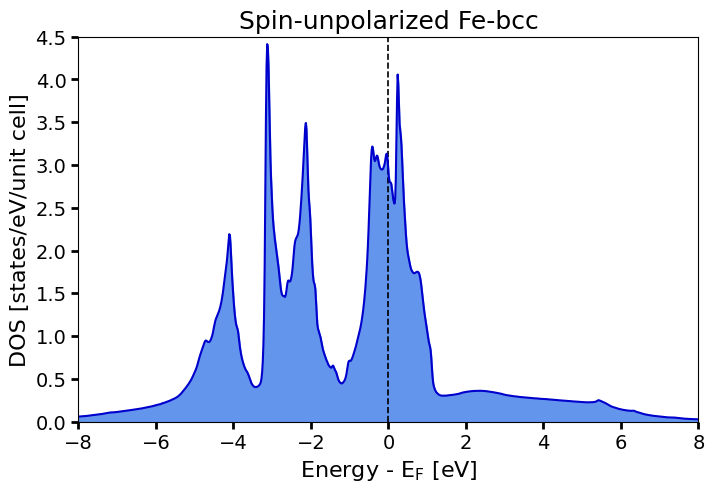

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.title("Spin-unpolarized Fe-bcc", fontsize=18)
plt.xlabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylabel("DOS [states/eV/unit cell]", fontsize=16)

plt.ylim([0, 4.5])
plt.xlim([-8, 8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

e_fermi = 0.0
plt.axvline(x=e_fermi, color="black", linestyle='--', linewidth=1.2)

plt.rcParams["axes.linewidth"] = 2

plt.plot(dos_data.energy, dos_data.dos, color="mediumblue")
plt.fill_between(dos_data.energy, 0, dos_data.dos, color="cornflowerblue")

plt.show()

#### <span style="color:#15317E">Plotting the Band Structure</span>

Similarly to the case of the DOS, the band structure can also be plotted inside the jupyter notebook by parsing the **bandstructure.xml** output file:

In [4]:
from excitingtools.exciting_obj_parsers.ks_band_structure import parse_band_structure

bandstructure_xml = os.path.join(os.getcwd(), 'run_spin_tutorial/noSPIN/bandstructure.xml')
band_data = parse_band_structure(bandstructure_xml)

band_data.bands = band_data.bands * ha_to_ev
band_data.e_fermi = 0.0
vertices, labels = band_data.band_path()

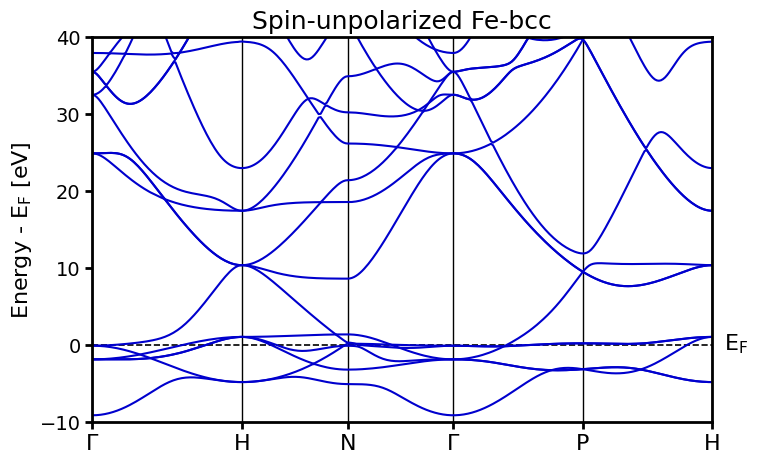

In [5]:
plt.figure(figsize=(8,5))
plt.title("Spin-unpolarized Fe-bcc", fontsize=18)
plt.ylabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylim([-10, 40])
plt.xlim([vertices[0], vertices[-1]])

plt.xticks(ticks=vertices, labels=labels, fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

plt.axhline(y=band_data.e_fermi, color="black", linestyle='--', linewidth=1.2)

for i in range(len(band_data.vertices)):
    plt.axvline(x=vertices[i], color="black", linewidth=1)

plt.rcParams["axes.linewidth"] = 2

plt.text(5.1, -0.6, "$\mathregular{E_F}$", fontsize=16)

plt.plot(band_data.flattened_k_points, band_data.bands, color="mediumblue")

plt.show()

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Spin-Polarized Ground State</span>

In the previous example the spin of the electrons is not taken into account. However, it is well known that iron is a magnetic material. In this kind of materials spin up electrons behave differently from spin down ones. In this section you will learn how to include spin degrees of freedom in **exciting** calculations.

You may start by creating a subdirectory **SPIN** in which you will run the calculation.

In [ ]:
%%bash
cd run_spin_tutorial
mkdir SPIN
cd ..

The next step is to modify the input file input.xml for making it suitable for spin-polarized calculations and to save it in the subdirectory **SPIN**. First of all, you may want to change the label of the calculation using

```xml
...
   <title>Spin-polarized Fe-bcc</title>
...
```
The main change is the inclusion of the element <code><span style="color:green">spin</span></code> inside the <code><span style="color:green">groundstate</span></code> element.

```xml
...
   <groundstate 
      do="fromscratch"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"    
      ngridk="8 8 8"
      stype="Gaussian"
      swidth="0.01"
      nempty="10">
 
      <spin 
         bfieldc="0.0 0.0 -4.0" 
         reducebf="0.5"
         spinorb="false">
      </spin>
 
   </groundstate>
...
```

In [ ]:
spin_str = """
      <spin 
         bfieldc="0.0 0.0 -4.0" 
         reducebf="0.5"
         spinorb="false">
      </spin>

   </groundstate>
"""

input_str_spin = input_str.replace('</groundstate>', spin_str)
input_str_spin = input_str_spin.replace('<title>Spin-unpolarized Fe-bcc</title>', ' <title>Spin-polarized Fe-bcc</title>')

with open(os.path.join(os.getcwd(), 'run_spin_tutorial/SPIN/input.xml'), "w") as fid:
    fid.write(input_str_spin)

The presence of the <code><span style="color:green">spin</span></code> element will tell to **exciting** to initialize the spin-polarized calculations. The relevant attributes of the <code><span style="color:green">spin</span></code> element are described in the following Table.

Attribute|Description
:-----------|:--------------------------------
<code><span style="color:mediumblue">bfieldc</span></code>|Specifies the cartesian coordinates of the external magnetic field required in spin-polarized calculations to break spin symmetry. In case of collinear magnetism, it is important to note that the preferable direction of the magnetic field should be selected along the z-axis (the axis of the spin quantization). Another important notice is that the amplitude of this field may play a crucial role to converge the system to the state with the right magnetic moment. Thus, as in the case of bulk iron, one has to specify rather high value of the field to obtain the magnetic state.
<code><span style="color:mediumblue">reducebf</span></code>|If one searches the ground state in absence of magnetic field, this attribute specifies which portion of the starting field is acting at each step during the self-consistent cycle (see more in **[Input Reference](http://exciting.wikidot.com/ref:input)**).
<code><span style="color:mediumblue">spinorb</span></code>|Should be set to **"true"** to include the spin-orbit coupling (**"false"** by default).

The way in which **exciting** deals with spin-polarized systems (the so-called "*second-variational approach*", described, e.g., in **<span style="color:firebrick">Singh-2006</span>**) requires also the explicit specification in the input of the attribute <code><span style="color:mediumblue">nempty</span></code> inside the <code><span style="color:green">groundstate</span></code> element.

Attribute|Description
:-----------|:--------------------------------
<code><span style="color:mediumblue">nempty</span></code>|Determines the size of the "*second-variational*" Hamiltonian. The optimized value should be chosen on the basis of a convergence test.

As before, you may run the calculation by executin the **exciting_smp** binary in the subdirectory **SPIN**.

In [ ]:
%%bash
cd run_spin_tutorial/SPIN
module load intel
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ../..

The main output file INFO.OUT contains information on the magnetic moments of the spin-polarized phase. These moments are written at each iteration. The values of the magnetic moments at the last SCF cycle should look like the following.

```
...
Moments :
     interstitial                           :        -0.00911718
     moment in muffin-tin spheres :
                  atom     1    Fe          :         1.98008333
     total moment in muffin-tins            :         1.98008333
     total moment                           :         1.97096615
```
Furthermore, you can visualize the new electronic band-structure and density of states by proceeding as for the spin-unpolarized case.

In [6]:
import numpy as np

dos_out = os.path.join(os.getcwd(), 'run_spin_tutorial/SPIN/TDOS.OUT')
dos_data = parse_obj_gw_dos(dos_out)

dos_data.energy = dos_data.energy * ha_to_ev
dos_data.dos = dos_data.dos / ha_to_ev

dos_spin_up = dos_data.dos[dos_data.dos >= 0]
dos_spin_down = dos_data.dos[dos_data.dos < 0]

energy_spin_up = np.split(dos_data.energy,2)[0]
energy_spin_down = np.split(dos_data.energy,2)[1]

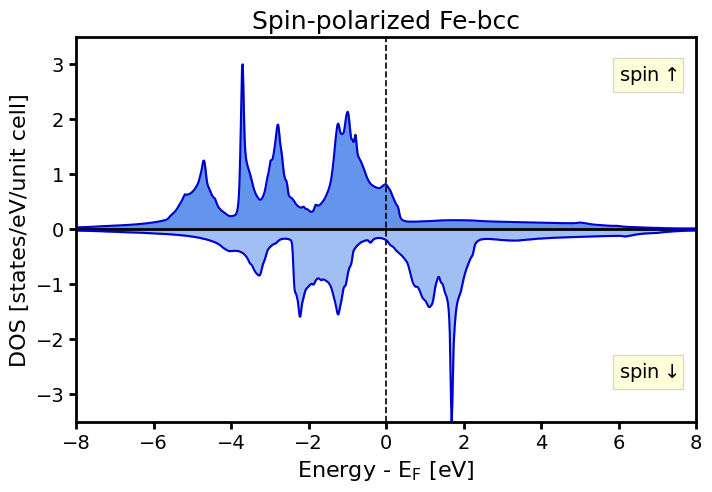

In [7]:
plt.figure(figsize=(8,5))
plt.title("Spin-polarized Fe-bcc", fontsize=18)
plt.xlabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylabel("DOS [states/eV/unit cell]", fontsize=16)

plt.ylim([-3.5, 3.5])
plt.xlim([-8, 8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

e_fermi = 0.0
plt.axvline(x=e_fermi, color="black", linestyle='--', linewidth=1.2)

plt.rcParams["axes.linewidth"] = 2
plt.axhline(y=0.0, color="black", linewidth=2)

plot1 = plt.plot(energy_spin_up, dos_spin_up, color="mediumblue")
plt.fill_between(energy_spin_up, 0, dos_spin_up, color="cornflowerblue")
plot2 = plt.plot(energy_spin_down, dos_spin_down, color="mediumblue")
plt.fill_between(energy_spin_down, 0, dos_spin_down, color="#a2bff4")

plt.text(6, 2.7, r'spin$\uparrow$', fontsize=14, bbox={'facecolor': 'yellow', 'alpha': 0.15, 'pad': 4})
plt.text(6, -2.7, r'spin$\downarrow$', fontsize=14, bbox={'facecolor': 'yellow', 'alpha': 0.15, 'pad': 4})

plt.show()

In [8]:
bandstructure_xml = os.path.join(os.getcwd(), 'run_spin_tutorial/SPIN/bandstructure.xml')
band_data = parse_band_structure(bandstructure_xml)

band_data.bands = band_data.bands * ha_to_ev
band_data.e_fermi = 0.0
vertices, labels = band_data.band_path()

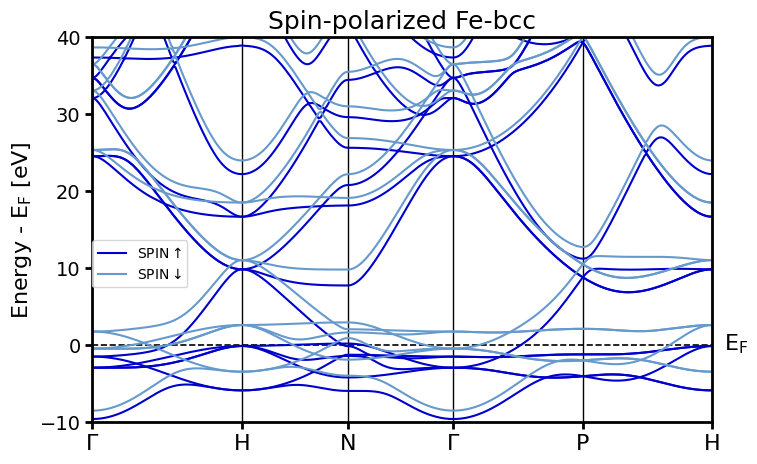

In [9]:
from matplotlib.lines import Line2D

plt.figure(figsize=(8,5))
plt.title("Spin-polarized Fe-bcc", fontsize=18)
plt.ylabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylim([-10, 40])
plt.xlim([vertices[0], vertices[-1]])

plt.xticks(ticks=vertices, labels=labels, fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

plt.axhline(y=band_data.e_fermi, color="black", linestyle='--', linewidth=1.2)

for i in range(len(band_data.vertices)):
    plt.axvline(x=vertices[i], color="black", linewidth=1)

plt.rcParams["axes.linewidth"] = 2

plt.text(5.1, -0.6, "$\mathregular{E_F}$", fontsize=16)

plt.plot(band_data.flattened_k_points, band_data.bands[:, :int(band_data.n_bands/2)], color="mediumblue")
plt.plot(band_data.flattened_k_points, band_data.bands[:, int(band_data.n_bands/2):], color="#6699cc")


LDA_label = Line2D([0], [0], label=r'SPIN$\uparrow$', color='mediumblue')
EXX_label = Line2D([0], [0], label=r'SPIN$\downarrow$', color='#6699cc')
plt.legend(handles=[LDA_label,EXX_label], loc=(0,0.35))

plt.show()

As you can see the main difference with the spin-unpolarized case is now the explicit distinction between electrons with spin up and spin down.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Anti-Ferromagnetic Phase</span>

Now we will learn how to initialize calculations for materials with anti-ferromagnetic (**AFM**) type of spin ordering. As an example, we consider a hypothetical **AFM** phase of bcc iron. In oder to realize the anti-ferromagnetic order, we need at least two nonequivalent atoms per cell. To do this with we simply apply the (standard) definition of the bcc lattice as a simple cubic (**SC**) lattice with a basis consisting of two atoms.

Let us now create a **<span style="color:firebrick">new</span>** input file **input.xml** in a new subdirectory **AFM**. The file should contain the following the following lines, corresponding to the hypothetical AFM phase of bcc Fe.

```xml
<input>
 
   <title>Anti-ferromagnetic Fe-bcc</title>
 
   <structure speciespath="$EXCITINGROOT/species">
      <crystal scale="5.200">
         <basevect> 1.0  0.0  0.0</basevect>
         <basevect> 0.0  1.0  0.0</basevect>
         <basevect> 0.0  0.0  1.0</basevect>
      </crystal>
      <species speciesfile="Fe.xml" rmt="2.0">
         <atom coord="0.00000 0.00000 0.00000" bfcmt="0.0 0.0  2.0"/>
         <atom coord="0.50001 0.50001 0.50001" bfcmt="0.0 0.0 -2.0"/>
      </species>
   </structure>
 
   <groundstate
      do="fromscratch"
      xctype="GGA_PBE_SOL"
      rgkmax="8.0"    
      ngridk="6 6 6"
      stype="Gaussian"
      swidth="0.01"
      nempty="20"
      epsengy="5.d-6"
      niterconvcheck="1"> 
 
      <spin/>
 
   </groundstate>
 
   <properties>
       <dos
         nsmdos="2"
         ngrdos="300"
         nwdos="1000"
         winddos="-0.3 0.3"/>
      <bandstructure>
         <plot1d>
            <path steps="300">
               <point coord="0.0  0.0  0.0" label="Gamma"/>
               <point coord="0.0  0.5  0.0" label="X"/>
               <point coord="0.5  0.5  0.0" label="M"/>
               <point coord="0.0  0.0  0.0" label="Gamma"/>
               <point coord="0.5  0.5  0.5" label="R"/>
               <point coord="0.0  0.5  0.0" label="X"/>
            </path>
         </plot1d>
      </bandstructure>
   </properties>
 
</input>
```

In [ ]:
%%bash
cd run_spin_tutorial
mkdir AFM
cd ..

In [ ]:
xml_str = re_input(notebook, "Anti-ferromagnetic Fe-bcc")
input_str = xml_str.replace("$EXCITINGROOT/species", f"{exciting_species}")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_spin_tutorial/AFM/input.xml'), "w") as fid:
    fid.write(input_str)

Here, the relevant difference with respect to the other calculations is the presence of the additional attribute <code><span style="color:mediumblue">bfcmt</span></code> inside the <code><span style="color:green">atom</span></code> element. This attribute plays a similar role as the attribute <code><span style="color:mediumblue">bfieldc</span></code> but only inducing the local atomic (muffin-tin) magnetic moment. The presence of this magnetic moment breaks the symmetry of the crystal and make the two basis atoms indeed nonequivalent. Since in this example we do not desire any external magnetic field or spin-orbit coupling, we can skip the explicit specification of the attributes inside the <code><span style="color:green">spin</span></code> element, keeping them to the default values.

Notice also that the path for the electronic band-structure in this example corresponds to the simple cubic supercell.

Following the steps as in the previous sections, we can calculate the total energy of the system and the local atomic magnetic moments.

In [ ]:
%%bash
cd run_spin_tutorial/AFM
module load intel
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ../..

Once the run is finished, proceed as in the other sections to visualize the density of states.

In [10]:
dos_out = os.path.join(os.getcwd(), 'run_spin_tutorial/AFM/TDOS.OUT')
dos_data = parse_obj_gw_dos(dos_out)

dos_data.energy = dos_data.energy * ha_to_ev
dos_data.dos = dos_data.dos / ha_to_ev

dos_spin_up = dos_data.dos[dos_data.dos >= 0]
dos_spin_down = dos_data.dos[dos_data.dos < 0]

energy_spin_up = np.split(dos_data.energy,2)[0]
energy_spin_down = np.split(dos_data.energy,2)[1]

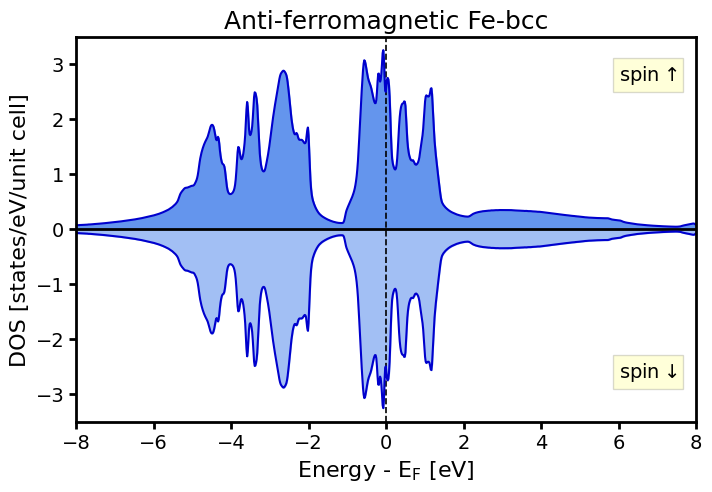

In [11]:
plt.figure(figsize=(8,5))
plt.title("Anti-ferromagnetic Fe-bcc", fontsize=18)
plt.xlabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylabel("DOS [states/eV/unit cell]", fontsize=16)

plt.ylim([-3.5, 3.5])
plt.xlim([-8, 8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

e_fermi = 0.0
plt.axvline(x=e_fermi, color="black", linestyle='--', linewidth=1.2)

plt.rcParams["axes.linewidth"] = 2
plt.axhline(y=0.0, color="black", linewidth=2)

plot1 = plt.plot(energy_spin_up, dos_spin_up, color="mediumblue")
plt.fill_between(energy_spin_up, 0, dos_spin_up, color="cornflowerblue")
plot2 = plt.plot(energy_spin_down, dos_spin_down, color="mediumblue")
plt.fill_between(energy_spin_down, 0, dos_spin_down, color="#a2bff4")

plt.text(6, 2.7, r'spin$\uparrow$', fontsize=14, bbox={'facecolor': 'yellow', 'alpha': 0.15, 'pad': 4})
plt.text(6, -2.7, r'spin$\downarrow$', fontsize=14, bbox={'facecolor': 'yellow', 'alpha': 0.15, 'pad': 4})
plt.show()

The electronic band-structure can be obtained as follows.

In [12]:
bandstructure_xml = os.path.join(os.getcwd(), 'run_spin_tutorial/AFM/bandstructure.xml')
band_data = parse_band_structure(bandstructure_xml)

band_data.bands = band_data.bands * ha_to_ev
band_data.e_fermi = 0.0
vertices, labels = band_data.band_path()

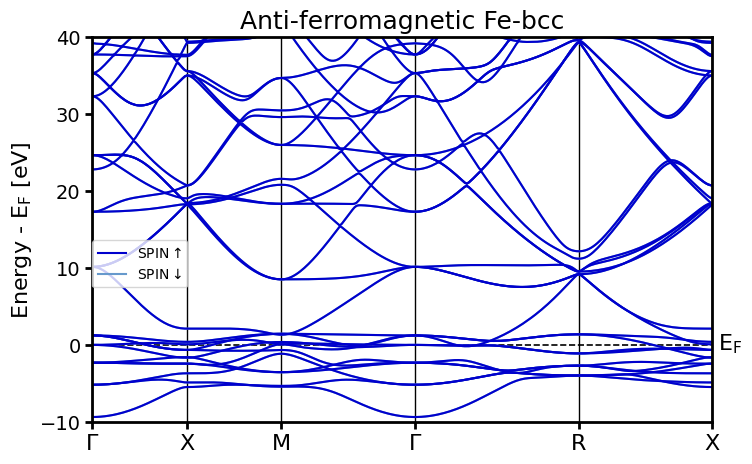

In [13]:
plt.figure(figsize=(8,5))
plt.title("Anti-ferromagnetic Fe-bcc", fontsize=18)
plt.ylabel("Energy - $\mathregular{E_F}$ [eV]", fontsize=16)
plt.ylim([-10, 40])
plt.xlim([vertices[0], vertices[-1]])

plt.xticks(ticks=vertices, labels=labels, fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(length=5,width=2)

plt.axhline(y=band_data.e_fermi, color="black", linestyle='--', linewidth=1.2)

for i in range(len(band_data.vertices)):
    plt.axvline(x=vertices[i], color="black", linewidth=1)

plt.rcParams["axes.linewidth"] = 2

plt.text(4, -0.6, "$\mathregular{E_F}$", fontsize=16)

plt.plot(band_data.flattened_k_points, band_data.bands[:, int(band_data.n_bands/2):], color="#6699cc")
plt.plot(band_data.flattened_k_points, band_data.bands[:, :int(band_data.n_bands/2)], color="mediumblue")


spin_up_label = Line2D([0], [0], label=r'SPIN$\uparrow$', color='mediumblue')
spin_down_label = Line2D([0], [0], label=r'SPIN$\downarrow$', color='#6699cc')
plt.legend(handles=[LDA_label,EXX_label], loc=(0,0.35))

plt.show()

Here, you can notice that, due to the symmetry of the anti-ferromagnetic phase, both the **DOS** and the electronic band-structures corresponding to the two spins (up and down) are identical.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Restarting Magnetic Calculations</span>

It is possible to restart a magnetic calculation using a previously saved potential in **STATE.OUT** as the initial guess. To do so, you have to specify the following attribute in the element <code><span style="color:green">groundstate</span></code>:

```xml
   <groundstate
      do="fromfile"
      ...>
   </groundstate>
```

The previous spin-polarized calculations in this tutorial have relied on the initial magnetic field to make sure that the self-consistent procedure converges to a spin-polarized solution. But you do not need this trick for a restarted calculation, because **STATE.OUT** contains an initial potential that is already close to a self-consistent one. You should not set the initial field exactly to **<span style="color:firebrick">0</span>**, because it will trigger a non-magnetic calculation. Instead, you can set it a small value, such as **<span style="color:firebrick">1d-6</span>**. In the calculation with spin-polarized iron, you would have to modify the input given in the **<span style="color:firebrick">Section 2</span>** as follows:

```xml
   <spin 
         bfieldc="0.0 0.0 -1d-6"
         reducebf="0.5"
         spinorb="false">
      </spin>
```

In the anti-ferromagnetic case, make the following changes:

```xml
      <species speciesfile="Fe.xml" rmt="2.0">
         <atom coord="0.00000 0.00000 0.00000" bfcmt="0.0 0.0  1d-6"/>
         <atom coord="0.50001 0.50001 0.50001" bfcmt="0.0 0.0 -1d-6"/>
      </species>
```

If you repeat an already converged calculation using this restart option, you will able to reach self-consistence in 4 steps. But it will take more of them if you change some other parameters (for example, <code><span style="color:mediumblue">rgkmax</span></code>, <code><span style="color:mediumblue">ngrik</span></code>) before the restart.

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

#### <span style="color:green">Exercises</span>

- At the given lattice constants, perform complete convergence test of the total energy and (if applicable) magnetic moments for the different phases with respect to the values of the attributes <code><span style="color:mediumblue">ngridk</span></code>, <code><span style="color:mediumblue">swidth</span></code>, <code><span style="color:mediumblue">rgkmax</span></code>, and <code><span style="color:mediumblue">nempty</span></code>.
- Perform the lattice optimization (see  **<span style="color:#3366BB">Volume optimization for cubic systems</span>**) for the paramagnetic, ferromagnetic, and anti-ferromagnetic phases. Compare the total energies for the optimized structures of the different phases. Which phase has the minimum total energy per atom? How does the energetics of the different phases depend on the main computational parameters?
- Calculate the magnetic moments of the optimized structure of the ferromagnetic phase. How does the obtained total magnetic moment compare with the one calculated in  **<span style="color:firebrick">Section 2</span>** and with the experimental value of about 2.12 $μ_B$?
- In order to visualize the volume dependence of total magnetic moment (magnetization) in the ferromagnetic phase, use the script **PLOT-totalmoment.py** inside the directory in which the volume optimization for this phase was performed.


<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Literature</span>
- **<span style="color:firebrick">Singh-2006</span>**: David J. Singh and Lars Nordström, "*Planewaves, Pseudopotentials, and the LAPW Method, Second Edition*", Springer 2006

<hr style="border:2px solid #DDD"> </hr>